In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt


2024-12-13 13:05:52.590692: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 13:05:52.610149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 13:05:52.631918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 13:05:52.638033: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 13:05:52.655556: I tensorflow/core/platform/cpu_feature_guar

Normal Data: Generated from a Gaussian distribution with mean 0 and standard deviation 1.
Anomalous Data: Generated from a uniform distribution with a wider range (-5 to 5).
Labels: 0 for normal data, 1 for anomalies.
The data is then split into training and testing sets.

In [2]:
np.random.seed(42)
normal_data = np.random.normal(0, 1, (1000, 10))  # Normal data
anomalous_data = np.random.uniform(-5, 5, (100, 10))  # Anomalies
data = np.vstack([normal_data, anomalous_data])
labels = np.hstack([np.zeros(1000), np.ones(100)])  # 0 = normal, 1 = anomaly


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


Input Layer: Accepts the input features (10 dimensions in this case).
Encoder:

    Reduces the input dimensionality through dense layers.
    Learns a compact representation of the data.

Decoder:

    Reconstructs the input data from the encoded representation.
    Uses sigmoid activation in the output layer to keep reconstructed values within [0, 1].

Loss Function: Mean Squared Error (mse) is used to measure reconstruction accuracy.

In [4]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

    Training Data: Only normal samples (y_train == 0) are used for training.
    Objective: The autoencoder learns to reconstruct normal data accurately. Anomalies will have higher reconstruction errors since they deviate significantly from the normal pattern.



In [5]:
autoencoder.fit(X_train[y_train == 0], X_train[y_train == 0], epochs=50, batch_size=32, shuffle=True)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.2461
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1117
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0049
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9244
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8649
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8056
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7506
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7464
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7069
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7083
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6767
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6850
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6450
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6367
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6387
Epoch 16/50
25/25 ━

Reconstruction Error: Mean squared error (MSE) between original and reconstructed inputs.
Threshold: Determined as the 95th percentile of reconstruction errors for normal data.
Anomalies: Data points with reconstruction errors exceeding the threshold are classified as anomalies.

In [6]:
reconstructed = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - reconstructed), axis=1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [7]:
threshold = np.percentile(mse[y_test == 0], 95)  # 95th percentile of normal data errors
anomalies = mse > threshold


    Histogram: Displays the distribution of reconstruction errors for normal and anomalous samples.
    Threshold Line: A vertical red line marks the threshold used to classify anomalies.

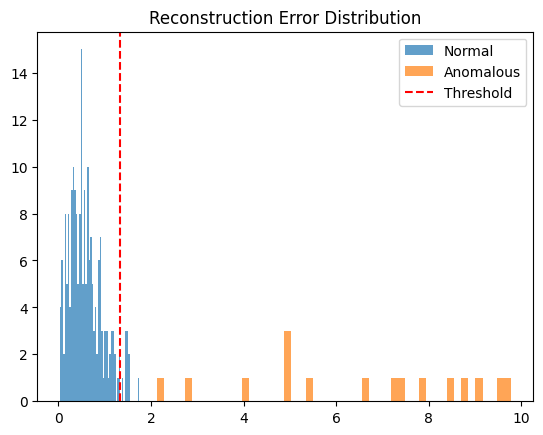

In [8]:
plt.hist(mse[y_test == 0], bins=50, alpha=0.7, label='Normal')
plt.hist(mse[y_test == 1], bins=50, alpha=0.7, label='Anomalous')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()
